# Create Patient Level File
## 03_create_patient_level_file

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 28/09/2025 | Adrienne | Created   | Created dataset for learning models | 
| 29/09/2025 | Martin | New   | Added function to filter by number of entries through percentile or absolute value | 
| 08/10/2025 | Adrienne | New | Added code to split datasets evenly

# Content

* [Loading Data](#loading-data)

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from datetime import datetime
import seaborn as sns
from datetime import date
from sklearn.model_selection import train_test_split

### Loading Data

In [ ]:
# readin clean datafiles
path = "../data/clean/"
claim_df =  pd.read_pickle(path + 'claim.pkl')

## Filtering Data

Added configurations to filter the data based on HCPCS and number of claims

1. `filter_by`: "percentile" | "entries"
2. `threshold`: Selected percentile or number of entries __GREATER THAN__ specified value

NOTE: Currently min number of claims is grouped on `patient_medicare_number`

In [3]:
def filter_claims(df: pd.DataFrame, filter_by: str, threshold: int):
  orig_df = df.copy()

  # Get length of diagnosis, hcpcs and procedure lists
  df['diagnosis_ls_len'] = df['diagnosis_ls'].str.len()
  df['hcpcs_ls_len'] = df['hcpcs_ls'].str.len()
  df['procedure_ls_len'] = df['procedure_ls'].str.len()

  # Remove entries with no HCPCS
  df = df[df['hcpcs_ls_len'] != 0]
  
  # Remove claims where unique_claim_ID is not nine in length - if rows without HCPCS are dropped then this is not necessary
  df['len_claim'] = df['unique_claim_ID'].str.len()
  df = df[ df['len_claim'] == 9]
  
  # Remove claims prior to 2012 
  # 95% of data is from then onwards.  As there are great differences in medical care 
  # through the decades want a more recent time period
  df['year'] = df['billablePeriod_start'].apply(lambda x: x[:4])
  df = df[ df['year'].astype(int) >= 2012]
  
  # dropping hcpcs codes that are not five in length
  df['hcpcs_ls'] = df['hcpcs_ls'].apply(lambda x: [code for code in x if len(code) == 5])

  # Filter on percentile or number of entries for each patient_medicare_number
  claim_count_by_medicare = df.groupby('patient_medicare_number').count()['billablePeriod_end'].reset_index()
  if filter_by == "percentile":
    perc = np.percentile(claim_count_by_medicare['billablePeriod_end'], threshold)
    print(f"Min number of claims: {perc}")
    selected_medicare_numbers = claim_count_by_medicare[claim_count_by_medicare['billablePeriod_end'] >= perc]['patient_medicare_number']
    print(f"Number of patient medicare numbers selected: {len(selected_medicare_numbers)}")
  elif filter_by == "entries":
    idx = np.where(claim_count_by_medicare['billablePeriod_end'] >= threshold)
    selected_medicare_numbers = claim_count_by_medicare.iloc[idx]['patient_medicare_number']
    print(f"Number of patient medicare numbers selected: {len(selected_medicare_numbers)}")
  else:
    print("Please check that your entries are valid")
    return

  # Get only the entries with selected medicare numbers
  df = df[df['patient_medicare_number'].isin(selected_medicare_numbers)]
  print()
  print(f"Previous number of entries: {orig_df.shape[0]}")
  print(f"Current number of entries: {df.shape[0]}")
  return df

In [ ]:
filter_by = "percentile"
threshold = 20

claim_fil_df = filter_claims(claim_df, filter_by=filter_by, threshold=threshold)

/var/folders/h7/vnb5cqf52l31_n7r6zv3j6z80000gn/T/ipykernel_1073/1701100949.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['len_claim'] = df['unique_claim_ID'].str.len()


### Create Columns

In [78]:
# prior to creating list columns want to sort claims by date
claim_fil_df = claim_fil_df.sort_values(by=['patient_medicare_number', 'billablePeriod_start'])

In [79]:
# Create a number of claims column
vals = claim_fil_df['patient_medicare_number'].value_counts()
vals_df = pd.DataFrame({'number_of_claims': vals})
claim_fil_df = pd.merge(claim_fil_df, vals_df, how = 'left', on = 'patient_medicare_number')

In [80]:
# Combined DRG column
claim_fil_df['drg_code'] = claim_fil_df['drg_code'].apply( lambda x : '{0:0>3}'.format(x)) 
grp_ser = claim_fil_df.groupby('patient_medicare_number')['drg_code'].apply(list)
grp_df = pd.DataFrame( {'drg_ls': grp_ser})
grp_df['drg_ls'] = grp_df['drg_ls'].apply(lambda x: [code for code in x if code != 'nan' ])
claim_fil_df = pd.merge(claim_fil_df, grp_df, how = 'left', on = 'patient_medicare_number')

In [81]:
# Combined HCPCS column
grp_ser = claim_fil_df.groupby('patient_medicare_number')['hcpcs_ls'].apply(list)
grp_df = pd.DataFrame( {'combined_hcpcs_ls': grp_ser})
grp_df['combined_hcpcs_ls'] = grp_df['combined_hcpcs_ls'].apply(lambda x: [code for list in x for code in list ])
claim_fil_df = pd.merge(claim_fil_df, grp_df, how = 'left', on = 'patient_medicare_number')

In [82]:
# Combined ICD10 column
grp_ser = claim_fil_df.groupby('patient_medicare_number')['diagnosis_ls'].apply(list)
grp_df = pd.DataFrame( {'combined_diagnosis_ls': grp_ser})
grp_df['combined_diagnosis_ls'] = grp_df['combined_diagnosis_ls'].apply(lambda x: [code for list in x for code in list ])
claim_fil_df = pd.merge(claim_fil_df, grp_df, how = 'left', on = 'patient_medicare_number')


In [ ]:
# Combined admitting diagnosis column
grp_ser = claim_fil_df.groupby('patient_medicare_number')['admitting_diagnosis'].apply(list)
grp_df = pd.DataFrame( {'combined_admitting_diagnosis_ls': grp_ser})
grp_df['combined_admitting_diagnosis_ls'] = grp_df['combined_admitting_diagnosis_ls'].apply(lambda ls: [x for x in ls if x != 'nan'])
claim_fil_df = pd.merge(claim_fil_df, grp_df, how = 'left', on = 'patient_medicare_number')

In [ ]:
# Combined principal diagnosis column
grp_ser = claim_fil_df.groupby('patient_medicare_number')['principal_diagnosis'].apply(list)
grp_df = pd.DataFrame( {'combined_principal_diagnosis_ls': grp_ser})
grp_df['combined_principal_diagnosis_ls'] = grp_df['combined_principal_diagnosis_ls'].apply(lambda ls: [x for x in ls if x != 'nan'])
claim_fil_df = pd.merge(claim_fil_df, grp_df, how = 'left', on = 'patient_medicare_number')

In [83]:
# Combined unique_claim_ID
claim_fil_df['unique_claim_ID'] = claim_fil_df['unique_claim_ID'].apply( lambda x : '{0:0>3}'.format(x)) 
grp_ser = claim_fil_df.groupby('patient_medicare_number')['unique_claim_ID'].apply(list)
grp_df = pd.DataFrame( {'unique_claim_ls': grp_ser})
grp_df['unique_claim_ls'] = grp_df['unique_claim_ls'].apply(lambda x: [code for code in x if code != 'nan' ])
claim_fil_df = pd.merge(claim_fil_df, grp_df, how = 'left', on = 'patient_medicare_number')

In [84]:
# Combined billablePeriod_start
claim_fil_df['billablePeriod_start'] = claim_fil_df['billablePeriod_start'].apply( lambda x : '{0:0>3}'.format(x)) 
grp_ser = claim_fil_df.groupby('patient_medicare_number')['billablePeriod_start'].apply(list)
grp_df = pd.DataFrame( {'billablePeriod_start_ls': grp_ser})
grp_df['billablePeriod_start_ls'] = grp_df['billablePeriod_start_ls'].apply(lambda x: [code for code in x if code != 'nan' ])
claim_fil_df = pd.merge(claim_fil_df, grp_df, how = 'left', on = 'patient_medicare_number')

In [85]:
# Combined billablePeriod_end
claim_fil_df['billablePeriod_end'] = claim_fil_df['billablePeriod_end'].apply( lambda x : '{0:0>3}'.format(x)) 
grp_ser = claim_fil_df.groupby('patient_medicare_number')['billablePeriod_end'].apply(list)
grp_df = pd.DataFrame( {'billablePeriod_end_ls': grp_ser})
grp_df['billablePeriod_end_ls'] = grp_df['billablePeriod_end_ls'].apply(lambda x: [code for code in x if code != 'nan' ])
claim_fil_df = pd.merge(claim_fil_df, grp_df, how = 'left', on = 'patient_medicare_number')

In [86]:
# Combined location_of_bill
claim_fil_df['location_of_bill'] = claim_fil_df['location_of_bill'].apply( lambda x : '{0:0>3}'.format(x)) 
grp_ser = claim_fil_df.groupby('patient_medicare_number')['location_of_bill'].apply(list)
grp_df = pd.DataFrame( {'location_of_bill_ls': grp_ser})
grp_df['location_of_bill_ls'] = grp_df['location_of_bill_ls'].apply(lambda x: [code for code in x if code != 'nan' ])
claim_fil_df = pd.merge(claim_fil_df, grp_df, how = 'left', on = 'patient_medicare_number')

In [87]:
# birthdate column - for whatever reason birthdates are not on every claim for a patient
grp_ser = claim_fil_df.groupby('patient_medicare_number')['contained_0_birthDate'].apply(list)
grp_df = pd.DataFrame({
  'birthdate_ls': grp_ser
})
grp_df['birthdate_ls'] = grp_df['birthdate_ls'].apply(set)
grp_df['birthdate'] = grp_df['birthdate_ls'].apply(lambda x: [code for code in x if pd.notnull(code)]).str[0]
grp_df['birthdate'] = pd.to_datetime(grp_df['birthdate'])
claim_fil_df = pd.merge(claim_fil_df, grp_df, how = 'left', on = 'patient_medicare_number')

# create age column

def calculate_age(birthdate):
    today = date.today()
    age = today.year - birthdate.year - ((today.month, today.day) < (birthdate.month, birthdate.day))
    return age

claim_fil_df['age'] = claim_fil_df['birthdate'].apply(calculate_age)

#### Drop columns so there is one row by for a patient

In [ ]:
keep_cols = ['patient_medicare_number', 'patient_first_name', 'patient_last_name', 'gender', 'birthdate', 'age', 'number_of_claims', 'drg_ls', 'combined_diagnosis_ls', 'combined_admitting_diagnosis_ls', 'combined_principal_diagnosis_ls', 'combined_hcpcs_ls', 'billablePeriod_start_ls', 'billablePeriod_end_ls', 'location_of_bill_ls', 'total_value']

In [89]:
claim_final_df = claim_fil_df[keep_cols]

In [ ]:
claim_final_df = claim_final_df.sort_values(by=['patient_medicare_number', 'patient_first_name'], ascending = [True, False])
claim_final_df.head()

,patient_medicare_number,patient_first_name,patient_last_name,gender,birthdate,age,number_of_claims,drg_ls,combined_diagnosis_ls,admitting_diagnosis,principal_diagnosis,combined_hcpcs_ls,billablePeriod_start_ls,billablePeriod_end_ls,location_of_bill_ls,total_value
0,1S00E00AA53,Jacquelynn,Conn188,female,1949-09-03,76.0,51,"[003, 001, 003, 003, 003, 003, 003, 003, 003, ...","[E669, I10, O039, C50929, E669, I10, O039, C50...",C50929,C50929,"[G8111, 99241, 99221, 99241, 99241, G0444, 992...","[2012-02-21, 2012-02-21, 2012-03-22, 2012-03-2...","[2012-02-22, 2012-02-21, 2012-03-22, 2012-03-2...","[002, 002, 002, 002, 002, 002, 002, 002, 002, ...",250.43
52,1S00E00AA98,Ermelinda1,Upton904,female,1947-10-23,77.0,21,"[001, 001]","[M810, J329, I10, M810, J329, I10, J0190, S635...",NaN,J0190,"[G0444, 99241, 99221, G0444, G0444, 99241, G04...","[2012-09-07, 2012-10-23, 2013-02-28, 2013-09-1...","[2012-09-07, 2012-10-23, 2013-03-01, 2013-09-1...","[002, 002, 002, 002, 002, 002, 002, 002, 002, ...",6665.78
72,1S00E00AC19,Mika226,Wehner319,female,1950-08-17,75.0,17,[001],"[D649, M179, J209, D649, M179, J209, D649, M17...",NaN,J209,"[99241, 99241, G0444, G0444, G9572, 99221, 992...","[2012-02-16, 2012-02-23, 2012-03-01, 2012-10-2...","[2012-02-16, 2012-02-23, 2012-03-01, 2012-10-2...","[002, 002, 002, 002, 002, 002, 002, 002, 002, ...",230.82
89,1S00E00AG22,Sanjuana98,Jacobi462,female,1949-05-02,76.0,23,[],"[M810, E785, E669, O039, M810, E785, E669, O03...",NaN,E785,"[99241, 99241, G0444, G9572, 99241, G0444, 992...","[2012-05-26, 2013-05-26, 2013-07-22, 2014-01-2...","[2012-05-26, 2013-05-26, 2013-07-22, 2014-01-2...","[002, 002, 002, 002, 002, 002, 002, 002, 002, ...",234.72
112,1S00E00AH76,Rosalina69,Reynolds644,female,1950-05-12,75.0,22,[],"[I10, K621, K635, J329, D649, I639, E785, I10,...",NaN,E785,"[99241, G0444, 99241, G0444, 99241, 99241, 992...","[2012-02-23, 2012-03-09, 2013-02-22, 2013-03-1...","[2012-02-23, 2012-03-09, 2013-02-22, 2013-03-1...","[002, 002, 002, 002, 002, 002, 002, 002, 002, ...",234.72


In [ ]:
# keep first row of group
claim_final_df = claim_final_df.groupby('patient_medicare_number', as_index=False).nth(0)

In [ ]:
# splitting dataset 50/50 for unsupervised and supervised learning
# making patient number y
y = claim_final_df['patient_medicare_number']
X = claim_final_df.iloc[:,1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)


In [13]:
claim_unsup = pd.concat([y_train, X_train], axis = 1)
claim_sup = pd.concat([y_test, X_test], axis = 1)

In [14]:
# save dataset
claim_unsup.to_pickle("../data/clean/patient_level.pkl")
claim_sup.to_pickle("../data/clean/patient_level_supervised.pkl")

## EDA

In [ ]:
# path = "../data/clean"
# claim_final_df = pd.read_pickle(f"{path}/patient_level.pkl")

Investigating Class Imbalance

In [ ]:
# Percentage breakdown
vals = claim_final_df['age'].value_counts(normalize=True).sort_index(ascending=True) * 100
pd.DataFrame({
  'age_breakdown': vals
}).head(22)

,age_breakdown
age,
68.0,2.101576
69.0,3.940455
70.0,4.991243
71.0,4.728546
72.0,6.567426
73.0,7.092820
74.0,7.968476
75.0,6.830123
76.0,6.217163


In [ ]:
# Percentage breakdown
vals = claim_final_df['gender'].value_counts(normalize=True) * 100
pd.DataFrame({
  'gender_breakdown': vals
}).head(22)

,gender_breakdown
gender,
female,53.403141
male,46.596859


Looking at length of combined_hcpcs_ls

In [8]:
claim_final_df['ls_len'] = claim_final_df['combined_hcpcs_ls'].str.len()

In [13]:
# Percentage breakdown
vals = claim_final_df['ls_len'].value_counts(normalize=True).sort_index(ascending=True) * 100
pd.DataFrame({
  'ls_breakdown': vals
}).head(50)

,ls_breakdown
ls_len,
14,1.570681
15,2.530541
16,1.919721
17,3.577661
18,3.054101
19,2.356021
20,2.268761
21,1.483421
22,1.832461


<Axes: xlabel='count', ylabel='ls_len'>

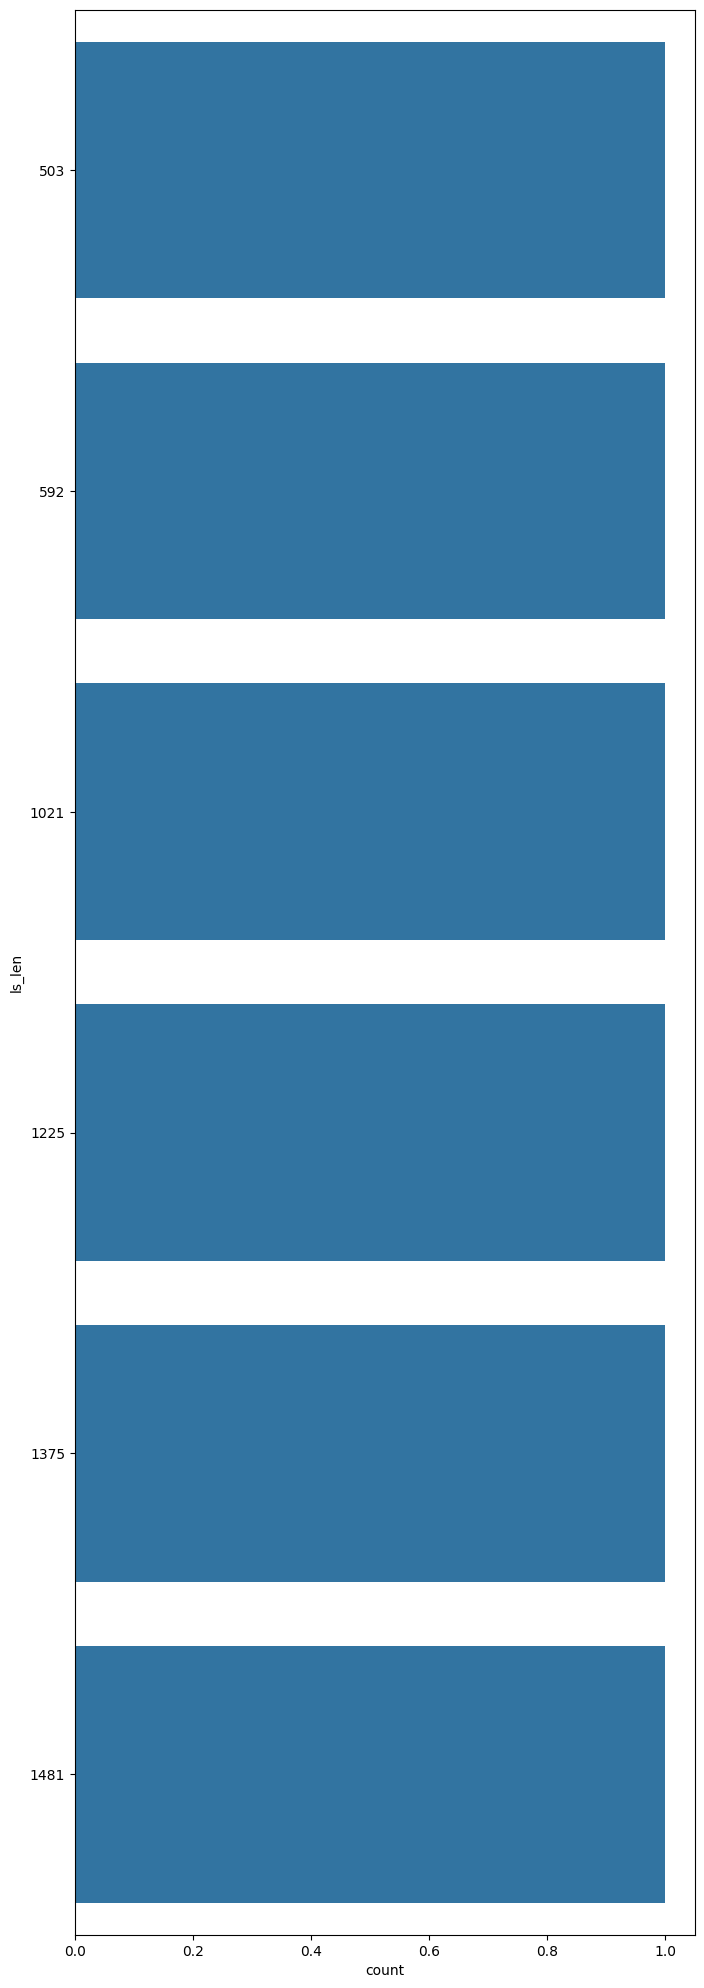

In [ ]:
fig, ax = plt.subplots(figsize=(8, 10))
#sns.countplot(y='ls_len', data=df, order=df['ls_len'].value_counts().index)
sns.countplot(y='ls_len', data=claim_final_df[claim_final_df['ls_len'] > 500])

This is the patient that has 1219 claims (once filtered) resulting in a combined_hcpcs_ls length of 1592

1S00E00GT33

In [101]:
claim_df[ claim_df['patient_medicare_number']== '1S00E00KH30'].tail()

,billablePeriod_end,billablePeriod_start,contained_0_birthDate,contained_0_gender,contained_0_id,contained_0_identifier_0_type_coding_0_code,contained_0_identifier_0_type_coding_0_display,contained_0_identifier_0_value,contained_0_name_0_family,contained_0_name_0_given,...,unique_claim_ID,drg_code,provider_number,national_provider_identifier,type_of_bill,claim_type,location_of_bill,diagnosis_ls,hcpcs_ls,procedure_ls
13397,2021-11-30,2021-11-30,NaN,female,patient,MC,Patient's Medicare Number,1S00E00KH30,Cremin,"[""S.""]",...,100341133,NaN,8888798286,NaN,NaN,professional,NaN,[K37],[99241],[]
13398,2021-12-21,2021-12-21,NaN,female,patient,MC,Patient's Medicare Number,1S00E00KH30,Cremin,"[""S.""]",...,100341136,NaN,8888850178,NaN,NaN,professional,NaN,[K37],[99241],[]
13399,2021-12-28,2021-12-28,NaN,female,patient,MC,Patient's Medicare Number,1S00E00KH30,Cremin,"[""S.""]",...,100341138,NaN,8888850178,NaN,NaN,professional,NaN,[K37],[99241],[]
13400,2022-01-04,2022-01-04,NaN,female,patient,MC,Patient's Medicare Number,1S00E00KH30,Cremin,"[""S.""]",...,100341140,NaN,8888850178,NaN,NaN,professional,NaN,[K37],[99241],[]
13401,2022-01-11,2022-01-11,NaN,female,patient,MC,Patient's Medicare Number,1S00E00KH30,Cremin,"[""S.""]",...,100341143,NaN,8888850178,NaN,NaN,professional,NaN,[K37],[99241],[]
